# LINMA2472 Homework 4
## Group 3 - Anthony Gerlache, Mathieu Jacob, Vladislav Kucheriavykh

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import NMF
from sklearn.cross_decomposition import CCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

import seaborn as sns
import scipy.io
from scipy import stats
from scipy.spatial.distance import cdist

In [24]:
df = fetch_california_housing(as_frame=True)
# df.target gives the target values column
# df.frame["feature_name"] gives the feature_name column 

# because the location impact the price
df.frame["Lat+Long"] = df.frame.apply(lambda row: row.Longitude + row.Latitude, axis=1)


y = df.frame["MedHouseVal"]
X = df.frame.drop(columns=["MedHouseVal"])

y = y[(np.abs(stats.zscore(X)) < 3).all(axis=1)] # remove outliers
X = X[(np.abs(stats.zscore(X)) < 3).all(axis=1)] # remove outliers

print(X.shape, y.shape)
print(X.head())

(19565, 9) (19565,)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Lat+Long  
0    -122.23    -84.35  
1    -122.22    -84.36  
2    -122.24    -84.39  
3    -122.25    -84.40  
4    -122.25    -84.40  


## Dataset visualization

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'Lat+Long'}>]], dtype=object)

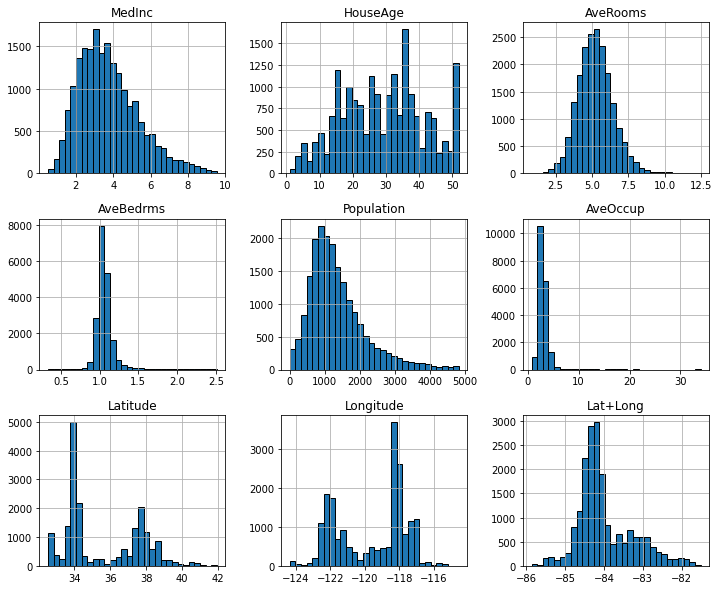

In [25]:
X.hist(figsize=(12, 10), bins=30, edgecolor="black")

In [26]:
# Limit computational time while keeping a representative sample
remove_n = 10000

drop_indices = np.random.choice(X.index, remove_n, replace=False)
X_subset = X.drop(drop_indices)
y_subset = y.drop(drop_indices)

In [27]:
def plot_embedding(data, labels) -> None:
    sns.scatterplot(data=data, x=data[:,0], y=data[:,1],
                    size=labels, hue=labels,
                    palette="viridis", alpha=0.5)
    plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
    plt.title("Median house value depending on\nthe first 2 PCA components")

### Estimation of the intrinsic dimension of the data, using the correlation dimension

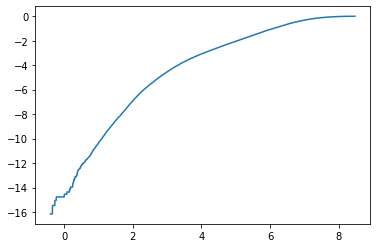

1.6792128903708343


In [28]:
def intrinsic_dimension(X):
    N,M = X.shape
    
    distances = np.array(cdist(X,X))
    distances = distances[distances != 0]   # remove zero distances because we're gonna take the log
    #print(distances)
    
    epsilon = np.logspace(np.log10(min(distances)), np.log10(max(distances)), num=N//3)   # N//3 values evenly spaced on a log scale
    C_hat = np.zeros(len(epsilon))

    for i in range(len(epsilon)):
        C_hat[i] = ((distances <= epsilon[i]).sum())/len(distances)
        
    x_reg = np.log(epsilon).reshape((-1,1))[1:-1]   # to avoid the extreme values
    y_reg = np.log(C_hat)[1:-1]
    regression = LinearRegression().fit(x_reg, y_reg)
    slope = regression.coef_[0]
        
    plt.plot(np.log(epsilon), np.log(C_hat))
    plt.show()
    
    return slope

intrinsic_dim = intrinsic_dimension(X.drop(np.random.choice(X.index, 15000, replace=False)))
print(intrinsic_dim)

### Principal Component Analysis

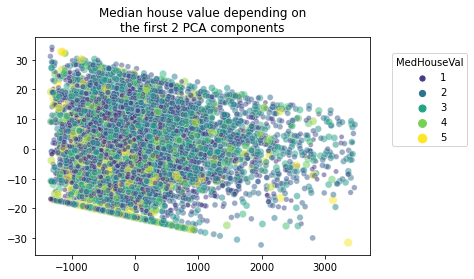

In [29]:
pca = PCA()
Xt_standard = pca.fit_transform(X_subset)
plot_embedding(Xt_standard, y_subset)

### Independent Component Analysis

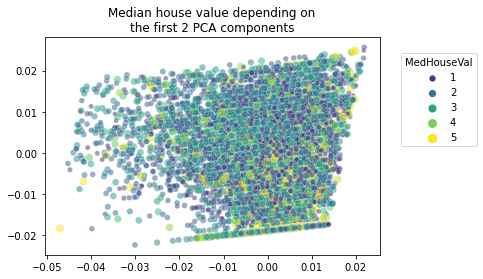

In [30]:
# ICA visualisation (unusual since it's not usually used for visualisation but to extract independent signals : https://scikit-learn.org/stable/modules/decomposition.html#independent-component-analysis-ica)
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2, whiten='unit-variance')
Xt_ica = ica.fit_transform(X_subset)
plot_embedding(Xt_ica, y_subset)

### kernel-PCA

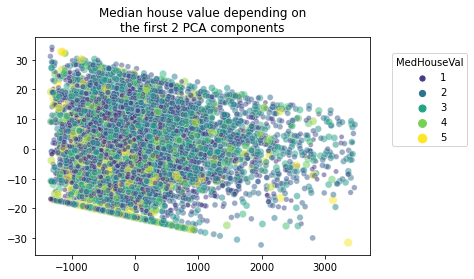

In [31]:
# kPCA visualisation with linear kernel (expected: same as PCA)
kpca = KernelPCA(n_components=2,kernel='linear')
Xt_linear = kpca.fit_transform(X_subset)
plot_embedding(Xt_linear, y_subset)

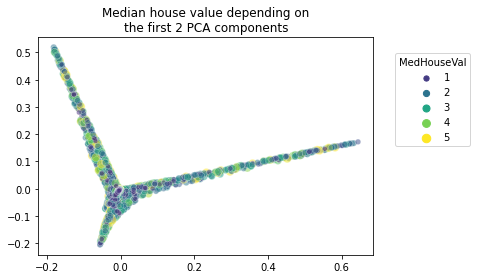

In [32]:
# kPCA visualisation with rbf kernel
kpca = KernelPCA(n_components=2,kernel='rbf', gamma=0.01)   # plot for several values of gamma : very different results
Xt_rbf = kpca.fit_transform(X_subset)
plot_embedding(Xt_rbf, y_subset)

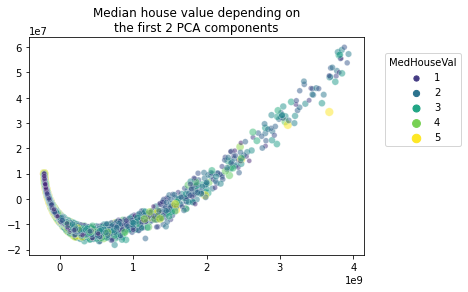

In [33]:
# kPCA visualisation with poly kernel
kpca = KernelPCA(n_components=2,kernel='poly', degree=3)   # could try other degrees than default 3
Xt_poly = kpca.fit_transform(X_subset)
plot_embedding(Xt_poly, y_subset)

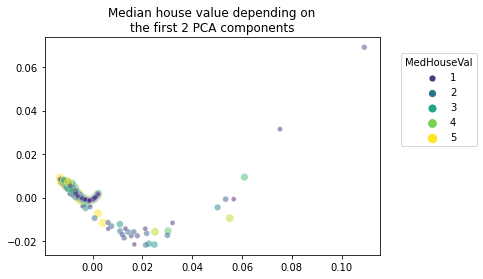

In [34]:
# kPCA visualisation with sigmoid kernel
kpca = KernelPCA(n_components=2,kernel='sigmoid', gamma=0.0001)   # need very small gamma to see something
Xt_sig = kpca.fit_transform(X_subset)
plot_embedding(Xt_sig, y_subset)

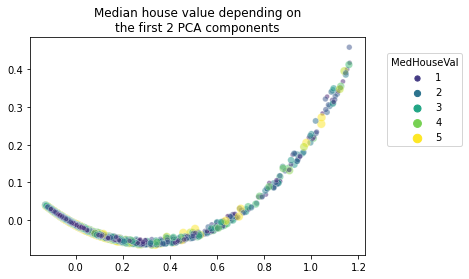

In [35]:
# kPCA visualisation with cosine kernel
kpca = KernelPCA(n_components=2,kernel='cosine')
Xt_cos = kpca.fit_transform(X_subset)
plot_embedding(Xt_cos, y_subset)

### Non-negative Matrix Factorisation
This method attempts to minimize the Frobenius norm of the difference between the data matrix $X$ and its factorization by two non-negative matrices $W$ and $H$. Therefore, $X$ is supposed to be non-negative as well.

In [39]:
print("Number of negative values in the dataset : ", X.lt(0).sum().sum())
print("Number of negative values in the dataset without Longitude : ", X.drop(columns=["Longitude","Lat+Long"]).lt(0).sum().sum())
# We can perform NMF on this modified data set

#nmf = NMF(n_components=2, init='random', max_iter=500)
nmf = NMF(n_components=2, init='nndsvda', max_iter=500) # nndsvda : no sparsity; indeed, data crammed together
Xt_nmf = nmf.fit_transform(X_subset.drop(columns=["Longitude","Lat+Long"]))
plot_embedding(Xt_nmf, y_subset)

Number of negative values in the dataset :  39130
Number of negative values in the dataset without Longitude :  0


ValueError: Negative values in data passed to NMF (input X)

### Metric multi-dimensional scaling
This method is based on distance preservation between the original space and the embedding.

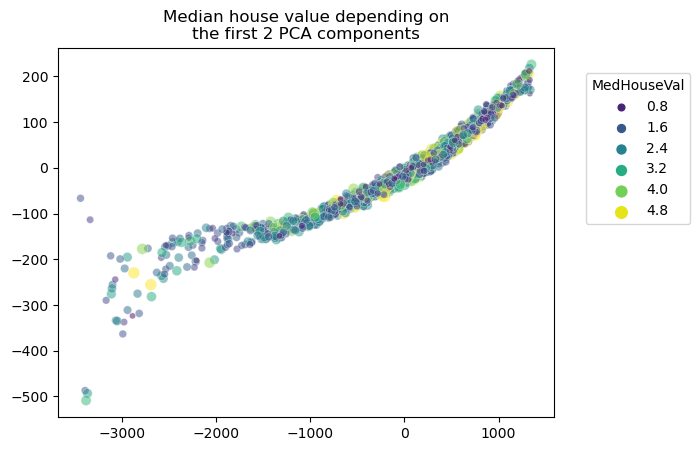

In [13]:
drop_mds = np.random.choice(X.index, 18000, replace=False)
y_mds = y.drop(drop_mds)

metric_mds = MDS(n_components=2, metric=True)
Xt_metric_mds = metric_mds.fit_transform(X.drop(drop_mds))
plot_embedding(Xt_metric_mds, y_mds)

### Non-metric multidimensional scaling 
This method is based on the preservation of the *order* of the distances/similarities. Since we only care about the order, the option <code>normalized_stress=True</code> can render the objective invariant under scaling.

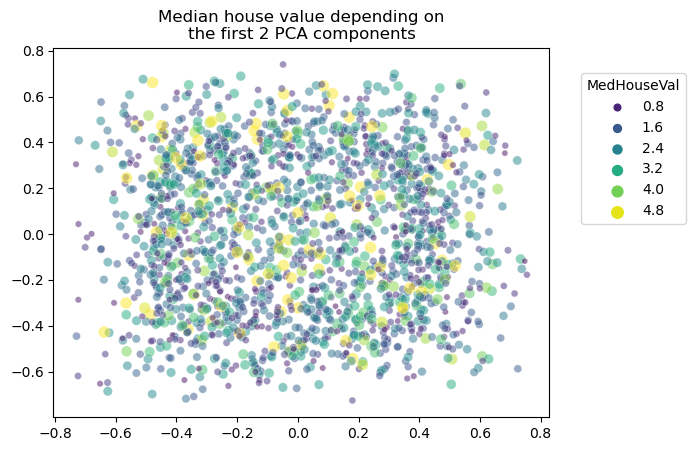

In [14]:
non_metric_mds = MDS(n_components=2, metric=False)
Xt_non_metric_mds = non_metric_mds.fit_transform(X.drop(drop_mds))
plot_embedding(Xt_non_metric_mds, y_mds)

### Isomap
This corresponds to metric MDS with a geodesic distance instead of a Euclidean one, which is approximated using shortest paths in a graph.

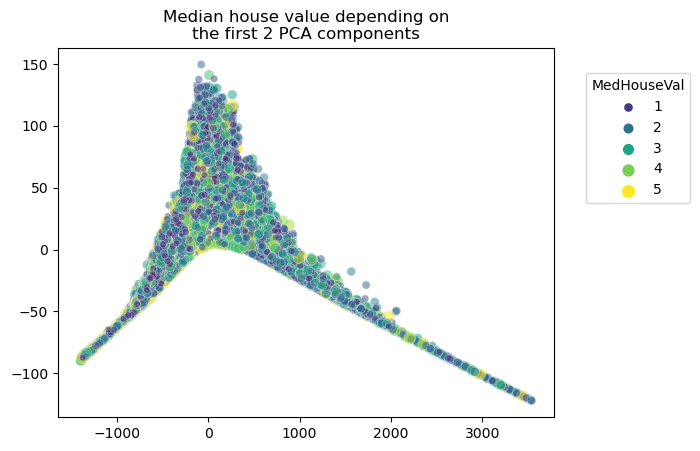

In [12]:
isomap = Isomap(n_components=2, n_neighbors=20)
Xt_isomap = isomap.fit_transform(X_subset)
plot_embedding(Xt_isomap, y_subset)

### Locally Linear Embedding
Based on comparison of linear combinations of neighbours between the HD space and the embedding.

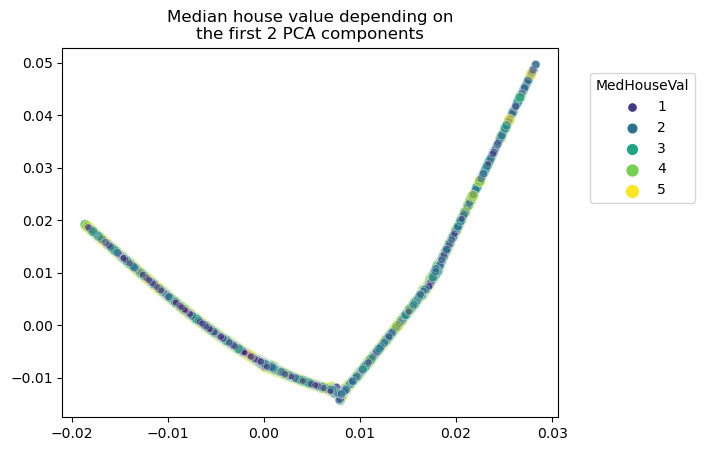

In [16]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=20, method='standard')
Xt_lle = lle.fit_transform(X_subset)
plot_embedding(Xt_lle, y_subset)

### Modified Locally Linear Embedding
Uses multiple weight vectors in order to address a regularisation problem that arives when <code>n_neighbors</code> is larger than the dimension of the original data (we consider <code>n_neighbors=20</code> to take advantage of this new method, and to stay consistent with Isomap).

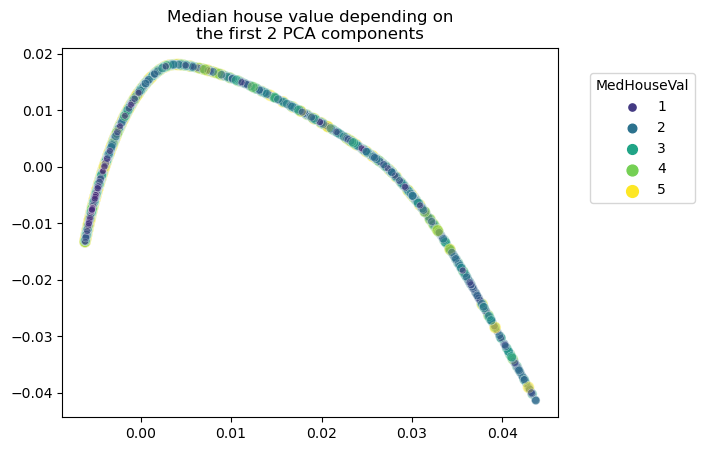

In [17]:
lle_modified = LocallyLinearEmbedding(n_components=2, n_neighbors=20, method='modified')
Xt_lle_modified = lle_modified.fit_transform(X_subset)
plot_embedding(Xt_lle_modified, y_subset)

### t-Distributed Stochastic Neighbour Embedding
Similarity-based dimensionality reduction method, which converts distances into probabilities and attempts to minimize the Kullback-Leibler divergence between the HD and LD distributions.

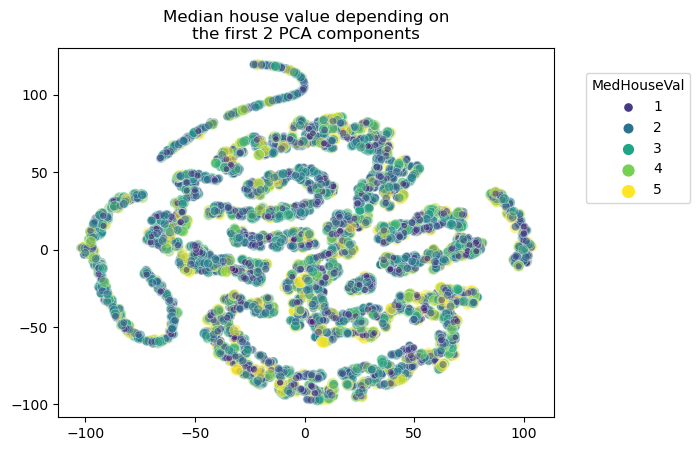

In [20]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20)
Xt_tsne = tsne.fit_transform(X_subset)
plot_embedding(Xt_tsne, y_subset)

### Various other plots

Text(0.5, 1.0, 'Median house value depending on\n their spatial location')

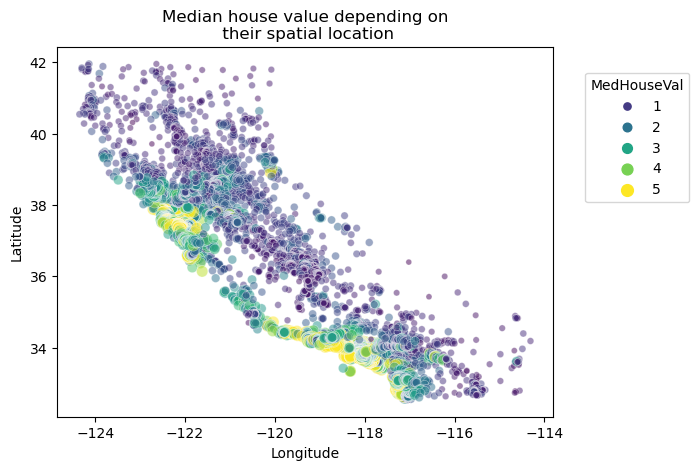

In [38]:
plt.subplots_adjust(hspace=0.7, wspace=0.4)

sns.scatterplot(data=df.frame, x="Longitude", y="Latitude",
                size="MedHouseVal", hue="MedHouseVal",
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
plt.title("Median house value depending on\n their spatial location")

Latitude      -0.144160
AveBedrms     -0.046701
Longitude     -0.045967
Population    -0.024650
AveOccup      -0.023737
HouseAge       0.105623
AveRooms       0.151948
MedInc         0.688075
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64


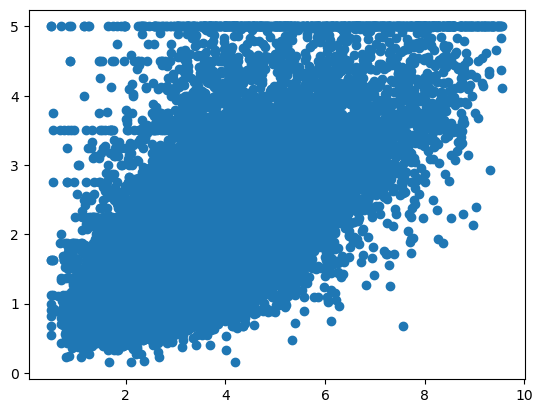

In [40]:
plt.scatter(X["MedInc"], y)
corr_matrix = df.frame.corr()
print(corr_matrix["MedHouseVal"].sort_values())

## Regression

In [23]:

# after scaling, cannot access with the scaled data with name of column feature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)   # only fit on X_train !!! No information must be leaked from the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

LatLong       -0.491520
Latitude      -0.144160
AveBedrms     -0.046701
Longitude     -0.045967
Population    -0.024650
AveOccup      -0.023737
HouseAge       0.105623
AveRooms       0.151948
MedInc         0.688075
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64


### Linear regression

In [16]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

score = lr_model.score(X_test,y_test)
print(score)

0.6162271478185639


In [17]:
br_model = BayesianRidge().fit(X_train,y_train)

score = br_model.score(X_test,y_test)
print(score)

0.6162425995528429
